In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input/sentiment-images-classifier/Sentiment classifier'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

main_folder = "/kaggle/input/sentiment-images-classifier/6 Emotions for image classification"
classes = os.listdir(main_folder)

data = []
labels = []

target_size = (224, 224)

for class_name in classes:
    class_folder = os.path.join(main_folder, class_name)
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        # Open image using PIL
        image = Image.open(image_path)
        # Resize image
        image = image.resize(target_size)
        # Convert image to numpy array
        image_array = np.array(image)
        if len(image_array.shape) == 3 and image_array.shape[2] == 3:
            data.append(image_array)
            labels.append(class_name)
        else:
            print("Skipping image:", image_path, "as it does not have 3 channels")

data = np.array(data)
labels = np.array(labels)

print("Shape of data array:", data.shape)
print("Shape of labels array:", labels.shape)

Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/pic92.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/ad963f5cc12f983d8367588d3b156a33--dark-eyes-horror-films.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/panico-540x361.png as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/fear/photodune-3175666-fear-m.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/sad/d2d5cb4e2792daba9680d721e737f0ef4.jpg as it does not have 3 channels
Skipping image: /kaggle/input/sentiment-images-classifier/6 Emotions for image classification/sad/4ca85a8078ecffeb4e8258f3635451a2.jpg as it does not have 3 channels
Skipping image: /kaggle/inpu

Data Prepocessing

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Normalization
data = data.astype('float32') / 255.0

# One-Hot Encoding
label_dict = {label: idx for idx, label in enumerate(np.unique(labels))}
labels_encoded = np.array([label_dict[label] for label in labels])
labels_one_hot = to_categorical(labels_encoded)

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(data, labels_one_hot, test_size=0.2, random_state=42)

print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of testing labels:", y_test.shape)


2024-05-10 18:27:35.514774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 18:27:35.514898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 18:27:35.698882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Shape of training data: (952, 224, 224, 3)
Shape of testing data: (238, 224, 224, 3)
Shape of training labels: (952, 6)
Shape of testing labels: (238, 6)


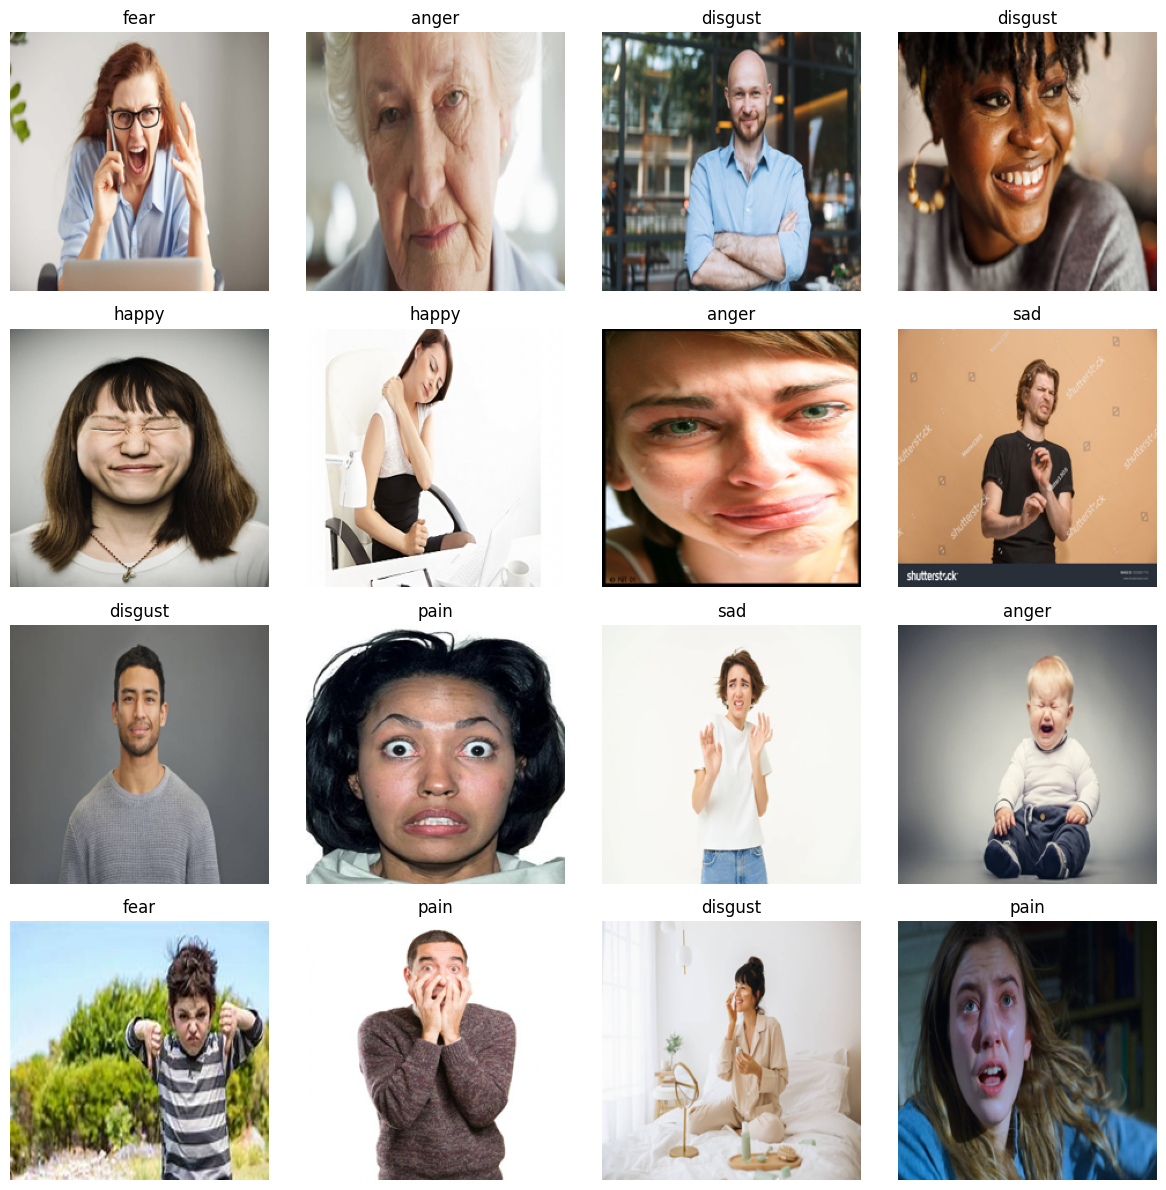

In [ ]:
import matplotlib.pyplot as plt

# Define a function to plot images
def plot_images(images, labels, class_names, rows=4, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i])
        # Set the corresponding label as title
        ax.set_title(class_names[labels[i]])
        # Remove ticks
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    # Define class names
class_names = os.listdir(main_folder)

# Plot a sample of images
plot_images(X_train, y_train.argmax(axis=1), class_names=class_names)




Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # randomly rotate images by 20 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by 10%
    height_shift_range=0.1, # randomly shift images vertically by 10%
    shear_range=0.2,        # randomly apply shear transformations
    zoom_range=0.2,         # randomly zoom into images
    horizontal_flip=True,   # randomly flip images horizontally
    fill_mode='nearest'     # how to fill in newly created pixels after transformations
)

# Example of applying data augmentation to the images
augmented_data = []
augmented_labels = []

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    img = img.reshape((1,) + img.shape)  # reshape image to (1, height, width, channels) for flow method
    j = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_data.append(batch[0])
        augmented_labels.append(label)
        j += 1
        if j >= 5:  # apply augmentation 5 times for each image
            break

# Convert augmented data and labels to numpy arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

# Verify the shapes of augmented data and labels
print("Shape of augmented data array:", augmented_data.shape)
print("Shape of augmented labels array:", augmented_labels.shape)


Shape of augmented data array: (4760, 224, 224, 3)
Shape of augmented labels array: (4760, 6)


MLP model

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

# Define MLP model
model = Sequential([
    Flatten(input_shape=(target_size[0], target_size[1], 3)),  # Flatten the input images
    Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
    Dense(len(class_names), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,486 (73.50 MB)

 Trainable params: 19,268,486 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.1841 - loss: 86.9872 - val_accuracy: 0.2563 - val_loss: 24.5342
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.2174 - loss: 18.2686 - val_accuracy: 0.2059 - val_loss: 22.9009
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.2703 - loss: 14.6397 - val_accuracy: 0.1975 - val_loss: 10.2295
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.2538 - loss: 13.2256 - val_accuracy: 0.2269 - val_loss: 12.2455
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.3268 - loss: 9.2768 - val_accuracy: 0.1303 - val_loss: 20.5052
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.3333 - loss: 7.9298 - val_accuracy: 0.2899 - val_loss: 12.2539
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.3110 - loss: 9.9597 - val_accuracy: 0.1723 - val_loss: 11.1107
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.3036 - loss: 6.1994 - va

In [ ]:
# Evaluate the model on the test data
_, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the overall accuracy
print("Overall Accuracy:", test_accuracy)


Overall Accuracy: 0.31512606143951416


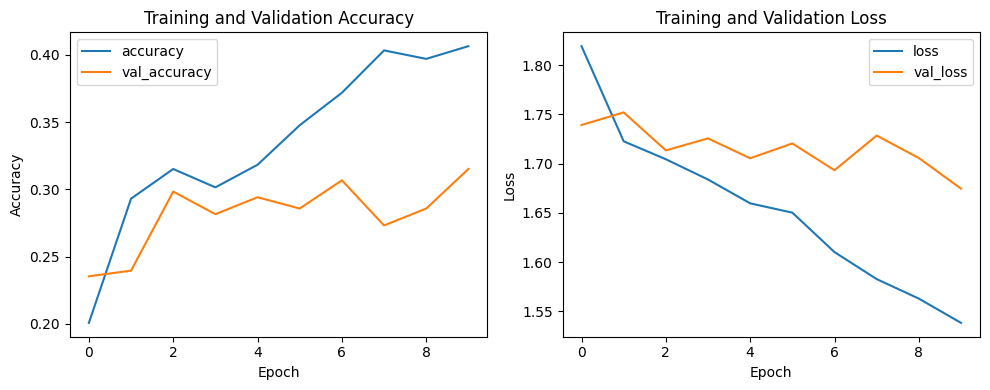

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[0])
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

# Plot training and validation loss
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[1])
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()


MlP Model with data augmentation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Define MLP model with L2 regularization
mlp_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Assuming input images are resized to 224x224
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(rate=0.3),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(rate=0.3),
    Dense(6, activation='softmax')
])

# Compile the model
mlp_model.compile(optimizer=Adam(learning_rate=2e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = mlp_model.fit(augmented_data, augmented_labels,
                        epochs=20,  # Increase epochs for early stopping to work effectively
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = mlp_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.1865 - loss: 28.6207 - val_accuracy: 0.2647 - val_loss: 24.0220
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.2148 - loss: 23.0754 - val_accuracy: 0.2521 - val_loss: 20.3573
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.1848 - loss: 19.6274 - val_accuracy: 0.2395 - val_loss: 17.4863
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.2107 - loss: 16.9158 - val_accuracy: 0.1891 - val_loss: 15.1859
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.2137 - loss: 14.6926 - val_accuracy: 0.1975 - val_loss: 13.2515
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.2309 - loss: 12.8398 - val_accuracy: 0.2647 - val_loss: 11.6167
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.2243 - loss: 11.2740 - val_accuracy: 0.2563 - val_loss: 10.2269
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.2367 - loss: 9.9

In [ ]:
predictions = model.predict(X_test)
print(predictions[:5])


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[7.0029865e-03 1.2656400e-04 9.9348575e-02 1.6176324e-05 8.8643050e-01
  7.0751635e-03]
 [2.0333712e-03 1.8164916e-01 6.5976614e-01 3.6417145e-02 2.7374621e-02
  9.2759624e-02]
 [1.7960088e-01 2.6657382e-02 6.8079448e-01 1.2201264e-02 1.0074543e-01
  5.7172753e-07]
 [1.0093241e-02 6.0095675e-02 4.9472147e-01 3.3903118e-02 4.0266287e-02
  3.6092016e-01]
 [7.6433986e-02 5.3154104e-03 3.3386841e-01 1.3977116e-02 4.9374750e-01
  7.6657511e-02]]


In [ ]:
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels[:5]

array([4, 2, 2, 2, 4])

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

        fear       0.00      0.00      0.00        38
         sad       1.00      0.03      0.05        39
        pain       0.15      0.77      0.25        31
     disgust       0.00      0.00      0.00        48
       happy       0.28      0.15      0.19        34
       anger       0.22      0.27      0.25        48

    accuracy                           0.18       238
   macro avg       0.28      0.20      0.12       238
weighted avg       0.27      0.18      0.12       238



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


HyperParameters Tuning

In [ ]:
# Define Hyperparameters
learning_rates = [1e-3, 1e-4]
batch_sizes = [32, 64]
num_neurons = [128, 256]
dropouts = [0.3, 0.5]
num_classes = 6



In [ ]:
# Step 2: Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Step 3: Define Model Architecture
def create_model(learning_rate, batch_size, num_neurons, dropout):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
        tf.keras.layers.Dense(num_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 4: Hyperparameter Tuning
best_val_accuracy = 0
best_hyperparameters = {}

for lr in learning_rates:
    for bs in batch_sizes:
        for nn in num_neurons:
            for do in dropouts:
                model = create_model(lr, bs, nn, do)
                history = model.fit(X_train, y_train, epochs=10, batch_size=bs, validation_data=(X_val, y_val))
                val_accuracy = history.history['val_accuracy'][-1]
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_hyperparameters = {'learning_rate': lr, 'batch_size': bs, 'num_neurons': nn, 'dropout': do}

# Step 5: Evaluate Final Model
final_model = create_model(best_hyperparameters['learning_rate'], best_hyperparameters['batch_size'],
                           best_hyperparameters['num_neurons'], best_hyperparameters['dropout'])
final_model.fit(data, labels_encoded, epochs=10, batch_size=best_hyperparameters['batch_size'])
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.1520 - loss: 64.3558 - val_accuracy: 0.1933 - val_loss: 1.7911
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.1908 - loss: 1.7945 - val_accuracy: 0.1933 - val_loss: 1.7908
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.1773 - loss: 1.7860 - val_accuracy: 0.1597 - val_loss: 1.7901
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.2017 - loss: 1.7897 - val_accuracy: 0.2017 - val_loss: 1.7900
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.1929 - loss: 1.7864 - val_accuracy: 0.2017 - val_loss: 1.7894
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.1659 - loss: 1.7871 - val_accuracy: 0.2017 - val_loss: 1.7888
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.1832 - loss: 1.7856 - val_accuracy: 0.2017 - val_loss: 1.7881
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.2000 - loss: 1.7798 - val_accur

In [ ]:
# Step 1: Make predictions using the trained model on the test data
predictions = model.predict(X_test)

# Step 2: Convert predicted labels and true labels back to their original form
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Step 3: Generate a classification report
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

           0       0.50      0.34      0.41        38
           1       0.75      0.23      0.35        39
           2       0.33      0.06      0.11        31
           3       0.23      0.75      0.35        48
           4       0.35      0.18      0.24        34
           5       0.41      0.19      0.26        48

    accuracy                           0.32       238
   macro avg       0.43      0.29      0.29       238
weighted avg       0.43      0.32      0.29       238



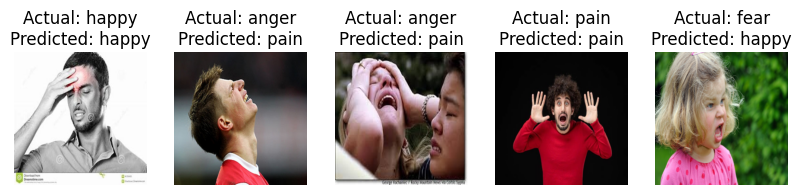

In [ ]:
import matplotlib.pyplot as plt

def visualize_images(images, labels, predictions, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_names[labels[i].argmax()] if len(labels[i].shape) > 0 else class_names[labels[i]]
        predicted_label = class_names[predictions[i].argmax()] if len(predictions[i].shape) > 0 else class_names[predictions[i]]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis('off')
    plt.show()

# Use the modified function to visualize images
visualize_images(X_test[:5], y_test[:5], y_pred[:5], class_names)
